<a href="https://colab.research.google.com/github/seoyujiin/esaa_ob/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9Cch4_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 딥러닝 텐서플로 p.182~200

##**PART 04 합성곱 신경망(CNN)**

###**04 위성 이미지 분류**

####**4-1 텐서플로 데이터셋 로드**

EuroSAT 데이터셋: 인공위성에서 지표면을 촬영한 이미지와 토지이용분류(Land Use and Land Cover) 값이 정리되어 있음

In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

* EuroSAT 데이터셋을 load 함수를 사용해 불러오면 '(훈련 셋, 검증 셋), 메타 정보' 순으로 정리되어 반환됨. info 변수에 저장되는 메타 정보는 with_info=True 옵션일 때만 불러올 수 있음. 즉 이 옵션이 False면 메타 정보 없이 (훈련 셋, 검증 셋) 형태의 투플로 반환됨
* data_dir 옵션에 파일 저장 위치를 지정하면 다운로드한 데이터셋 파일을 해당 위치에 저장함

In [ ]:
# EuroSAT 위성 사진 데이터셋 로드
DATA_DIR = "/content/drive/MyDrive/ESAA/OB/data"

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True, as_supervised=True, with_info=True, data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /content/drive/MyDrive/ESAA/OB/data/eurosat/rgb/2.0.0.incompleteOTVS5W/eurosat-train.tfrecord*...:  …

Dataset eurosat downloaded and prepared to /content/drive/MyDrive/ESAA/OB/data/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


→ 이미지는 (64, 64, 3) 형태

* 메타 정보를 할당받은 info 변수를 출력하면, 데이터셋에 대한 기본 정보를 보여줌

In [ ]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path=PosixGPath('/tmp/tmp1fmbvbt7tfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('im

→ 앞에서 EuroSAT 데이터셋의 2가지 유형 중에서 JPEG 이미지로 인코딩한 RGB 데이터셋을 다운로드한 상태

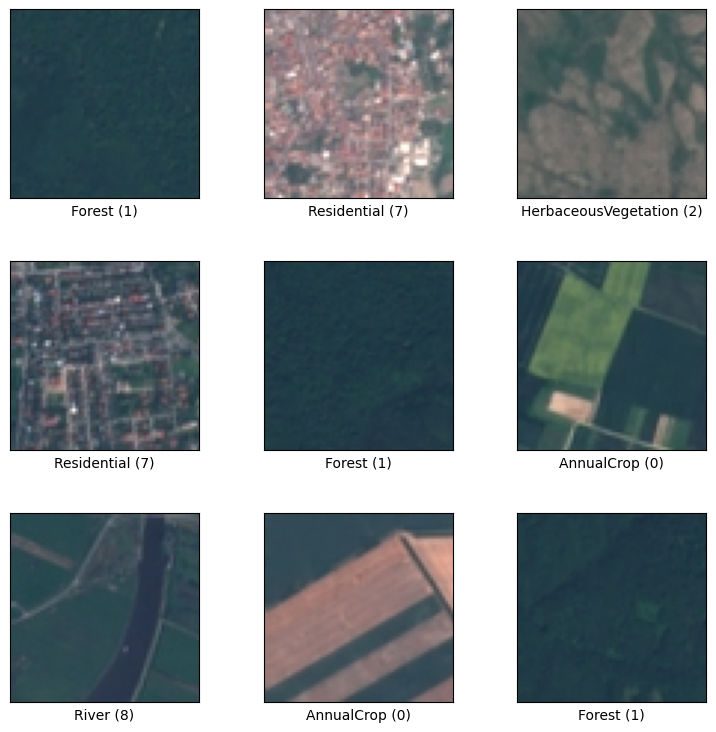

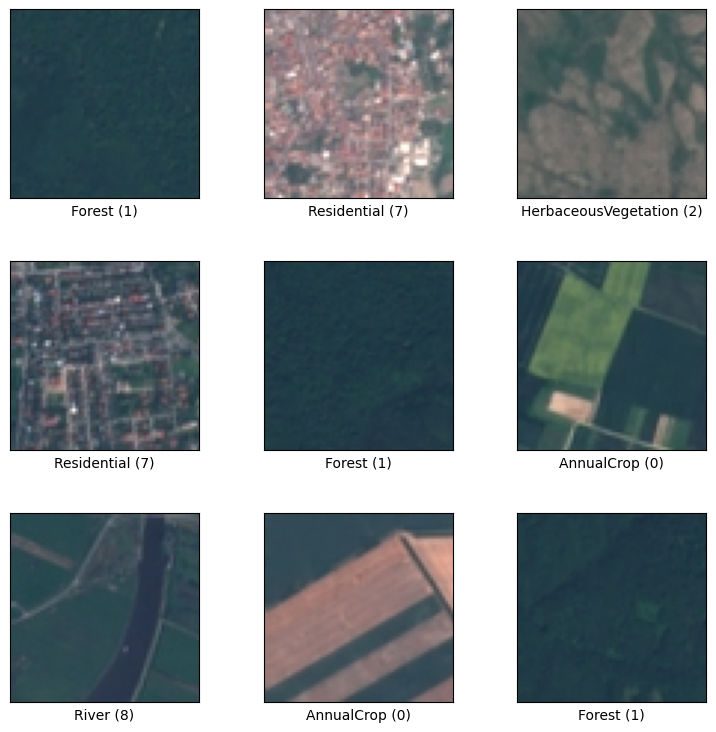

In [ ]:
# 샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력 - show_examples 함수 사용
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

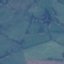
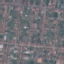
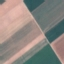
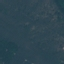
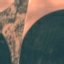
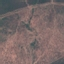
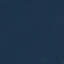
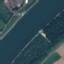
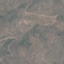
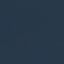

In [ ]:
# as_dataframe 함수 사용하여 샘플 이미지 10개 출력
tfds.as_dataframe(valid_ds.take(10), info)

→ 클래스 0은 경작지(AnnualCrop), 클래스 9는 바다/호수(SeaLake)를 나타냄

In [ ]:
# 토지이용분류에 해당하는 정답 클래스 개수는 10개
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [ ]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


→ 클래스 6은 영구작물(PermanentCrop)을 나타냄

####**4-2 데이터 전처리**

* 텐서플로 데이터셋을 사용하면 딥러닝 학습에 필요한 데이터셋을 쉽게 구할 수 있다는 장점 외에도 데이터 전처리 과정이 매우 쉽다는 장점을 가짐
* 데이터 전처리에 필요한 함수들을 제공하고 있을 뿐만 아니라, 텐서 연산을 효율적으로 처리할 수 있는 최적화를 지원함
* 텐서플로 데이터셋에 특화된 전처리 함수들 소개
  * 텐서플로 연산은 float32 숫자 값을 사용하기 때문에, cast 함수를 사용하여 자료형을 float32로 변환해 줌. 입력 이미지는 0~255 범위의 픽셀 값을 갖기 때문에 255로 나눠서 정규화함. 이 과정을 처리하는 preprocess_data 함수 정의
  * map 함수: 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드
    * num_parallel_calls 옵션을 오토튠(AUTOTUNE)으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화함
    * 오토튠을 적용하지 않으면 데이터를 읽어서 매핑하고 훈련하는 과정을 순차적으로 처리하기 때문에 시간이 오래 걸리지만, 오토튠을 적용하면 하드웨어 리소스를 병렬로 매핑하여 처리하기 떄문에 같은 작업을 훨씬 짧은 시간에 처리할 수 있게 됨
  * 정규화를 마친 데이터셋에 shuffle() 메소드를 적용하면 순서를 랜덤하게 섞어 줌. 모델의 일반화된 성능을 높이기 위해 훈련 데이터셋에서 미니 배치를 생성할 때 입력 순서에 무작위성을 부여하는 개념
  * BUFFER_SIZE를 1000으로 지정하고 BATCH_SIZE를 64로 지정했는데, 처음 1000개의 데이터를 가져와서 섞고, 여기서 64개의 데이터를 랜덤하게 선택해서 하나의 배치를 구성함(이때 64개가 추출되어 미니 배치를 구성하고 학습에 사용되면, 다시 64개의 데이터가 버퍼(buffer)에 추가되어 항상 1000개의 버퍼를 구성함)
  * prefetch() 메소드: 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리를 하도록 시스템 조율(병렬 처리를 통해 모델 훈련 시간을 단축시킴)

In [ ]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32) / 255.  # 0~1 정규화, float32 변환
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

####**4-3 모델 훈련 및 검증**

* 배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛을 2개 연결하고, Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 Sequential API로 생성

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

  model = tf.keras.Sequential([

      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
  ])
  return model

model = build_model()

In [ ]:
# 예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가지표 설정하고, 모델을 50 epoch 훈련시킴
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, validation_data=valid_data, epochs=50)

Epoch 1/50
338/338 [==============================] - 243s 710ms/step - loss: 1.5771 - accuracy: 0.4558 - val_loss: 1.7824 - val_accuracy: 0.4061
Epoch 2/50
338/338 [==============================] - 294s 871ms/step - loss: 1.2048 - accuracy: 0.5882 - val_loss: 0.8638 - val_accuracy: 0.7148
Epoch 3/50
338/338 [==============================] - 312s 925ms/step - loss: 1.0455 - accuracy: 0.6445 - val_loss: 0.8021 - val_accuracy: 0.7415
Epoch 4/50
338/338 [==============================] - 302s 894ms/step - loss: 0.9128 - accuracy: 0.6881 - val_loss: 0.6404 - val_accuracy: 0.7885
Epoch 5/50
338/338 [==============================] - 328s 970ms/step - loss: 0.8091 - accuracy: 0.7294 - val_loss: 0.5749 - val_accuracy: 0.8181
Epoch 6/50
338/338 [==============================] - 279s 826ms/step - loss: 0.7078 - accuracy: 0.7650 - val_loss: 0.5923 - val_accuracy: 0.8074
Epoch 7/50
338/338 [==============================] - 240s 709ms/step - loss: 0.6444 - accuracy: 0.7887 - val_loss: 0.5245 -

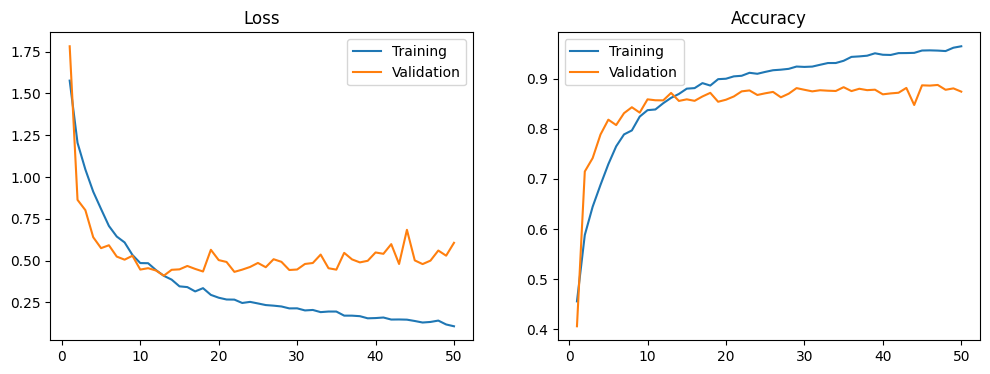

In [ ]:
# 손실함수, 정확도 그래프 그리기
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 50)

→ 모델은 10 epoch까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격하게 감소하지만 그 이후로는 검증 셋에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합 경향을 나타냄

####**4-4 데이터 증강(Data Augmentation)**

* 이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법 - 데이터 증강(Data Augmentation) 기법
  * 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식으로, 모델이 새로운 데이터에 대한 예측력을 강화하도록 하는 개념
  

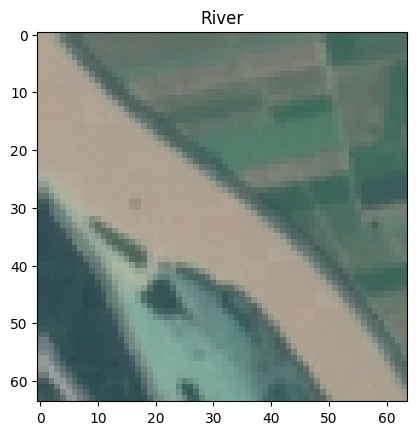

In [ ]:
# EuroSAT 데이터셋 중에서 하나의 샘플 이미지를 선택하여 시각화
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

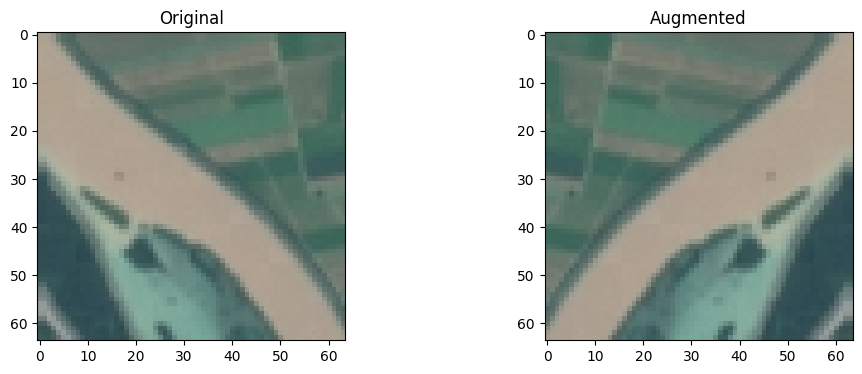

In [ ]:
# tf.image 모듈의 flip_left_right 함수 사용하여 이미지를 좌우 방향으로 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

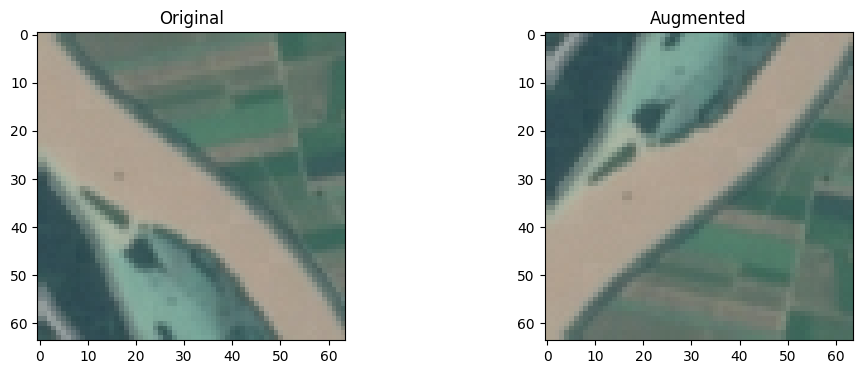

In [ ]:
# flip_up_down 함수 사용하여 이미지를 상하 방향으로 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

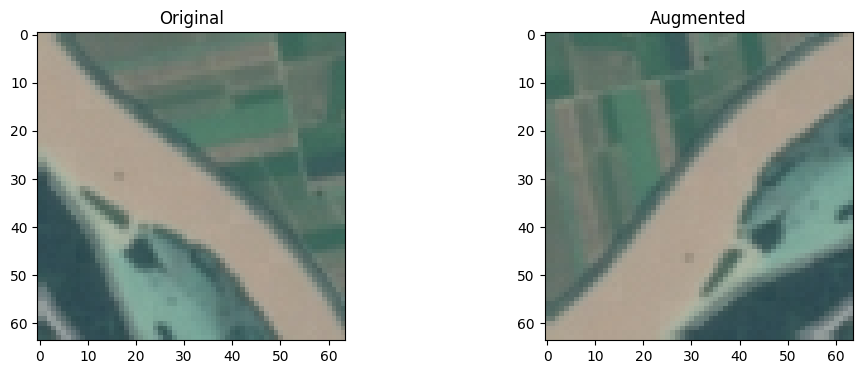

In [ ]:
# rot90 함수 사용하여 이미지를 반시계 방향으로 90도 회전시킴
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

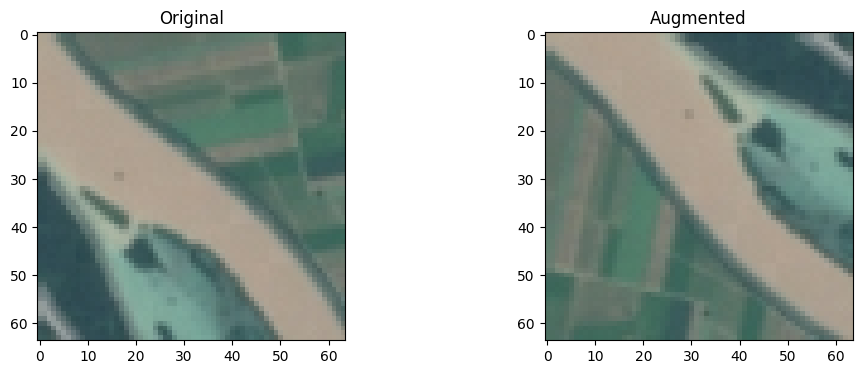

In [ ]:
# transpose 함수는 이미지 텐서 행렬의 행과 열의 위치를 바꿔줌(행렬의 도치)
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

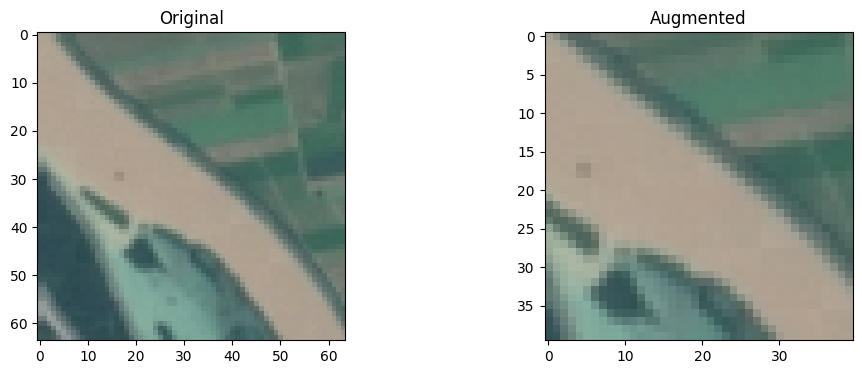

In [ ]:
# central_crop 함수는 이미지의 중심에서 일정 부분을 잘라냄
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

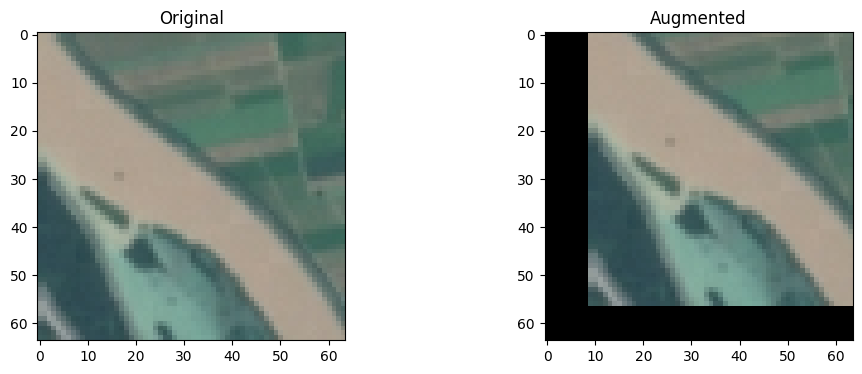

In [ ]:
# resize_with_crop_or_pad 함수 사용하여 원본 이미지의 크기를 키움
# random_crop 함수 사용하여 이미지를 원본 크기와 같게 자르면 원본 이미지가 상하좌우 랜덤한 방향으로 시프트(shift) 이동
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64+20, 64+20)  # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

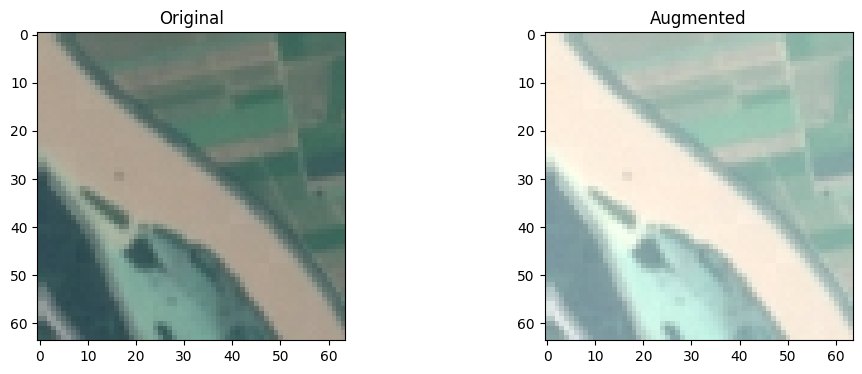

In [ ]:
# 이미지 밝기 조정
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

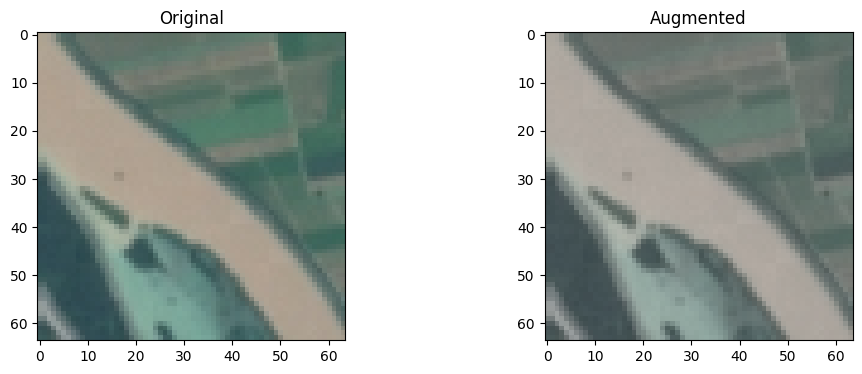

In [ ]:
# 이미지 채도 변경
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

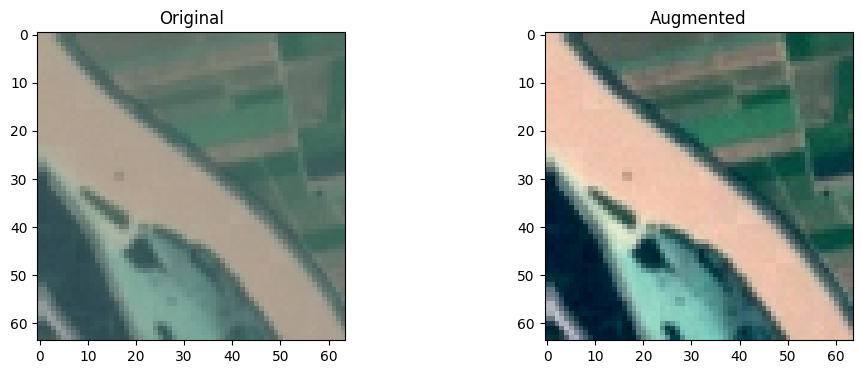

In [ ]:
# 이미지 대비 조정
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [ ]:
# 데이터 증강 및 전처리 수행하는 data_augmentation 사용자 함수 정의
# 이미지 증강 효과에 랜덤성 부여하기 위해 tf.image 모듈에서 지원하는 함수 중 'random_'으로 시작하는 함수 적용
# 이미지 증강 전처리
def data_augmentation(image, label):

  image = tf.image.random_flip_left_right(image)  # 좌우 반전
  image = tf.image.random_flip_up_down(image)  # 상하 반전
  image = tf.image.random_brightness(image, max_delta=0.3)  # 밝기 변화
  image = tf.image.random_crop(image, size=[64, 64, 3])

  image = tf.cast(image, tf.float32) / 255.  # 0~1 정규화

  return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
338/338 [==============================] - 240s 691ms/step - loss: 1.8716 - accuracy: 0.2996 - val_loss: 1.6332 - val_accuracy: 0.4333
Epoch 2/50
338/338 [==============================] - 222s 656ms/step - loss: 1.5635 - accuracy: 0.3908 - val_loss: 1.2909 - val_accuracy: 0.4989
Epoch 3/50
338/338 [==============================] - 231s 682ms/step - loss: 1.3976 - accuracy: 0.4569 - val_loss: 1.3206 - val_accuracy: 0.5098
Epoch 4/50
338/338 [==============================] - 223s 660ms/step - loss: 1.3222 - accuracy: 0.4988 - val_loss: 1.2157 - val_accuracy: 0.5498
Epoch 5/50
338/338 [==============================] - 214s 633ms/step - loss: 1.2189 - accuracy: 0.5390 - val_loss: 0.9340 - val_accuracy: 0.6754
Epoch 6/50
338/338 [==============================] - 222s 657ms/step - loss: 1.1674 - accuracy: 0.5665 - val_loss: 0.8921 - val_accuracy: 0.7030
Epoch 7/50
338/338 [==============================] - 222s 657ms/step - loss: 1.1021 - accuracy: 0.5913 - val_loss: 0.8825 -

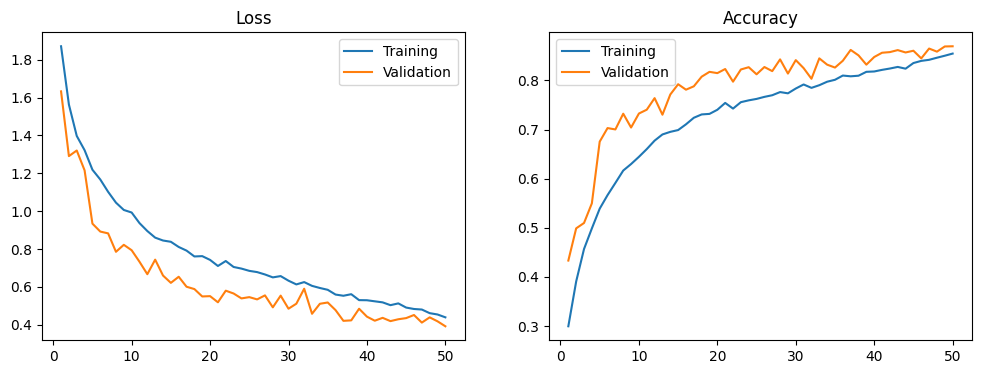

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 50)

→ 훈련 셋과 검증 셋에 대한 손실함수는 50 epoch 동안 계속 줄어들고 정확도는 조금씩 우상향하면서 개선되고 있음. 즉 과대적합 문제가 상당히 해소됨

####**4-5 ResNet 사전 학습 모델**

ResNet 모델 활용해 위성 이미지 분류

* 사전에 방대한 이미지로 훈련받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델 구성(전이 학습)
* 원래 ResNet 모델의 입력 크기는 (224, 224, 3) → input_shape 속성에 (64, 64, 3) 지정
* 분류하려는 클래스 레이블의 개수(10)를 classes 속성에 지정
* 기존 ResNet 모델의 Top 층은 이미지넷 경진 대회에 맞는 분류기이므로 include_top=False로 지정하여 Top 층 제거


In [ ]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                               weights='imagenet',
                               input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

→ NUM_CLASSES 변수는 위성 이미지의 클래스 레이블 개수인 10을 값으로 가지고 있음

→ 최종적으로 10개 클래스에 대한 다중 분류를 할 수 있도록 Dense 레이어의 노드 개수와 softmax 활성화 함수를 지정

In [ ]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

  model = tf.keras.Sequential([

      # Pre-trained Base
      pre_trained_base,
      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               